## Notebook for using machine learning and parliamentary questions to measure politicians' constituency service

This notebook contains the code for the analysis presented in my Using Machine Learning and Parliamentary Questions to Measure Politicians' Constituency Service blog post.

### Import the required libraries and functions

In [26]:
# numpy, pandas, counter
import numpy as np
import pandas as pd
from collections import Counter
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
# seaborn
import seaborn as sns
# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
# wordcloud
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 'large'

In [3]:
labelled = pd.read_csv('labelled.csv')

### Check that data was imported correctly

In [4]:
labelled.head(5)

,filename,date,speaker,X,Name,Party,Constituency.x,Female,Dynastic,Votes,Vote_share,Quota,ff,gov,docs,dail,ID_unit,Stratum,Local,labels
0,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,644,425,Bill Loughnane,Fianna Fail,Clare Galway South,0,0,6956,26.46,1.06,1,0,asked the minister for foreign affairs if he w...,20,6,1,0,not
1,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,644,425,Bill Loughnane,Fianna Fail,Clare Galway South,0,0,6956,26.46,1.06,1,0,asked the minister for foreign affairs if he i...,20,8,1,0,not
2,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,544,414,Thomas Hussey,Fianna Fail,Galway North East,0,0,5340,20.37,0.81,1,0,asked the minister for industry and commerce t...,20,22,1,1,local
3,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760325,754,237,Thomas Meaney,Fianna Fail,Cork Mid,0,1,10400,25.64,1.28,1,0,asked the minister for agriculture and fisheri...,20,154,1,1,local
4,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760205,797,585,Ciaran Murphy,Fianna Fail,Wicklow,0,0,4521,15.31,0.61,1,0,asked the minister for education the grants to...,20,252,1,0,not


### Get the question and label columns for text classification model

In [5]:
x = labelled['docs']
y = labelled[['labels']].values.flatten()
y = label_binarize(y, classes=['not', 'local']).ravel()

### Prepare data for analysis

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1253) #split data

In [8]:
count_vect = CountVectorizer(decode_error='ignore')
X_train_counts = count_vect.fit_transform(X_train)

In [9]:
print "There are {:,} words in the vocabulary.".format(len(count_vect.vocabulary_))
print X_train.shape
print len(X_train)
print Counter(y_train)

There are 5,913 words in the vocabulary.
(2000,)
(2000, 5913)
2000
Counter({0: 1196, 1: 804})


In [13]:
X_test_counts = count_vect.transform(X_test)

In [14]:
print X_test_counts.shape
print len(X_test)
print Counter(y_test)

(500, 5913)
500
Counter({0: 299, 1: 201})


### Use cross validation on training set to find optimal model

In [15]:
kf = KFold(n_splits=10, shuffle=True, random_state=1213)
f1_scorer = make_scorer(f1_score)

#### Logistic Regression with word counts

In [16]:
grid = {
        'C': [1, .9, .8, .7, .6, .5, .25, .1],
        'penalty' : ['l1', 'l2']
    }
logit = LogisticRegression()
loggs = GridSearchCV(logit, grid, scoring=f1_scorer, cv=kf)
loggs.fit(X_train_counts, y_train)
means = loggs.cv_results_['mean_test_score']
stds = loggs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, loggs.cv_results_['params']):
    print("F1-score: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

F1-score: 0.885 (+/-0.036) for {'penalty': 'l1', 'C': 1}
F1-score: 0.884 (+/-0.039) for {'penalty': 'l2', 'C': 1}
F1-score: 0.885 (+/-0.034) for {'penalty': 'l1', 'C': 0.9}
F1-score: 0.884 (+/-0.041) for {'penalty': 'l2', 'C': 0.9}
F1-score: 0.883 (+/-0.034) for {'penalty': 'l1', 'C': 0.8}
F1-score: 0.883 (+/-0.042) for {'penalty': 'l2', 'C': 0.8}
F1-score: 0.885 (+/-0.035) for {'penalty': 'l1', 'C': 0.7}
F1-score: 0.882 (+/-0.042) for {'penalty': 'l2', 'C': 0.7}
F1-score: 0.883 (+/-0.040) for {'penalty': 'l1', 'C': 0.6}
F1-score: 0.884 (+/-0.044) for {'penalty': 'l2', 'C': 0.6}
F1-score: 0.881 (+/-0.047) for {'penalty': 'l1', 'C': 0.5}
F1-score: 0.886 (+/-0.041) for {'penalty': 'l2', 'C': 0.5}
F1-score: 0.875 (+/-0.046) for {'penalty': 'l1', 'C': 0.25}
F1-score: 0.878 (+/-0.046) for {'penalty': 'l2', 'C': 0.25}
F1-score: 0.869 (+/-0.063) for {'penalty': 'l1', 'C': 0.1}
F1-score: 0.872 (+/-0.038) for {'penalty': 'l2', 'C': 0.1}


#### Multinomial Naive Bayes with counts

In [17]:
grid = {
        'alpha': [1, .8,.6, .4, .2]
    }
mnb = MultinomialNB()
mnbgs = GridSearchCV(mnb, grid, scoring=f1_scorer, cv=kf)
mnbgs.fit(X_train_counts, y_train)
means = mnbgs.cv_results_['mean_test_score']
stds = mnbgs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mnbgs.cv_results_['params']):
    print("F1-score: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

F1-score: 0.863 (+/-0.035) for {'alpha': 1}
F1-score: 0.861 (+/-0.036) for {'alpha': 0.8}
F1-score: 0.859 (+/-0.035) for {'alpha': 0.6}
F1-score: 0.858 (+/-0.041) for {'alpha': 0.4}
F1-score: 0.856 (+/-0.052) for {'alpha': 0.2}


#### Support vector machine with counts

In [18]:
grid = {
        'C': [1, .9, .8, .7, .6, .5]
    }
svc = SVC(kernel='linear')
svcgs = GridSearchCV(svc, grid, scoring=f1_scorer, cv=kf)
svcgs.fit(X_train_counts, y_train)
means = svcgs.cv_results_['mean_test_score']
stds = svcgs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svcgs.cv_results_['params']):
    print("F1-score: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

F1-score: 0.870 (+/-0.038) for {'C': 1}
F1-score: 0.871 (+/-0.036) for {'C': 0.9}
F1-score: 0.872 (+/-0.035) for {'C': 0.8}
F1-score: 0.872 (+/-0.038) for {'C': 0.7}
F1-score: 0.874 (+/-0.041) for {'C': 0.6}
F1-score: 0.876 (+/-0.043) for {'C': 0.5}


### Calculate test performance for each optimal model

In [19]:
logpreds = loggs.predict(X_test_counts)
print(classification_report(y_test, logpreds))
print accuracy_score(y_test, logpreds)

             precision    recall  f1-score   support

          0       0.90      0.95      0.93       299
          1       0.92      0.84      0.88       201

avg / total       0.91      0.91      0.91       500

0.908


In [20]:
mnbpreds = mnbgs.predict(X_test_counts)
print(classification_report(y_test, mnbpreds))
print accuracy_score(y_test, logpreds)

             precision    recall  f1-score   support

          0       0.90      0.92      0.91       299
          1       0.88      0.85      0.86       201

avg / total       0.89      0.89      0.89       500

0.908


In [21]:
svcpreds = svcgs.predict(X_test_counts)
print(classification_report(y_test, svcpreds))
print accuracy_score(y_test, logpreds)

             precision    recall  f1-score   support

          0       0.90      0.92      0.91       299
          1       0.88      0.85      0.87       201

avg / total       0.89      0.89      0.89       500

0.908


### Get most important features in logit model

In [22]:
def get_most_informative_features(vectorizer, clf, out=0, n=5):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.best_estimator_.coef_[0], feature_names))
    top = coefs_with_fns[:n] + coefs_with_fns[:-(n + 1):-1]
    df = pd.DataFrame(top, columns=['Coefficient', 'Word'])
    df = df.sort_values(by = 'Coefficient')
    return df

In [23]:
top_features = get_most_informative_features(vectorizer=count_vect, clf=loggs, out=0, n=5)

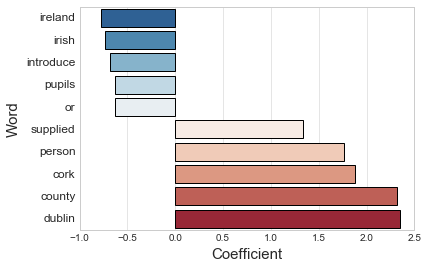

In [24]:
sns.set_style("whitegrid")
ax = sns.barplot(y="Word", x="Coefficient", data=top_features, palette="RdBu_r")
figure = ax.get_figure()    
figure.savefig("coefplot.png", dpi=350)

## Import unlabelled data

Note that I that I am not releasing this data as it is employed in ongoing research projects. Therefore it will not be possible to reproduce the analysis below.

In [27]:
unlabelled = pd.read_csv('unlabelled.csv')
X_unlabelled_counts = count_vect.transform(unlabelled['docs'])
print X_unlabelled_counts.shape

(305804, 5913)


In [29]:
unlabelled.head(5)

,filename,date,speaker,dail,X,Name,Party,Constituency.x,Female,Dynastic,Votes,Vote_share,Quota,ff,gov,docs
0,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,906,20,454,Michael O'Kennedy,Fianna Fail,Tipperary North,0,0,5709,20.14,0.81,1,0,and ruairí brugha asked the minister for forei...
1,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,906,20,454,Michael O'Kennedy,Fianna Fail,Tipperary North,0,0,5709,20.14,0.81,1,0,asked the minister for foreign affairs if the ...
2,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,313,20,385,Barry Desmond,Labour Party,Dun Laoghaire and Rathdown,0,0,5768,13.73,0.69,0,1,asked the minister for foreign affairs if he w...
3,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,198,20,344,Edward Collins,Fine Gael,Waterford,0,0,6719,21.78,0.87,0,1,asked the minister for foreign affairs if he i...
4,/gpfs/group/dynrr/ireland/xml_by_session/20/xm...,19760701,768,20,241,Bobby Molloy,Fianna Fail,Galway West,0,0,7028,28.31,1.13,1,0,asked the minister for foreign affairs if he h...


### Generate word cloud using the text from the unlabelled corpus

In [30]:
text = ' '.join(unlabelled['docs'].tolist())

In [31]:
stopwords = set(STOPWORDS)
stopwords.add("minister")
stopwords.add("asked")
stopwords.add("statement")
stopwords.add("make")
stopwords.add("will")
stopwords.add("matter")

In [32]:
wordcloud = WordCloud(background_color="white", max_words=2000, stopwords = stopwords,
                      max_font_size=40, random_state=42).generate(text)

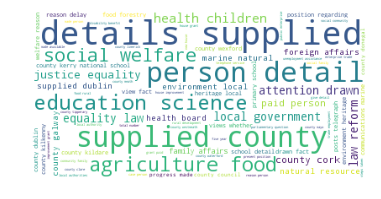

In [33]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('qs_wordcloud.png', dpi=650)

### Plot number of questions submitted over time

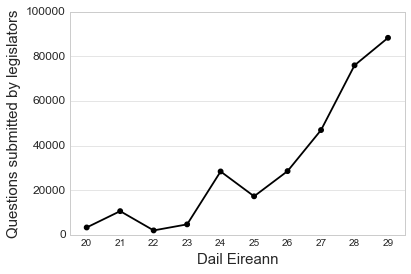

In [34]:
doccounts = unlabelled.groupby('dail')['dail'].count()
doccounts = pd.DataFrame({'Dail':doccounts.index, 'Questions':doccounts.values})
ax = sns.pointplot(x="Dail", y="Questions", data=doccounts, sharex=False, sharey=False, color='black')
ax.set(ylim=(0, None))
ax.set(xlabel='Dail Eireann', ylabel='Questions submitted by legislators')
figure = ax.get_figure()    
figure
figure.savefig("qstimeplot.png", dpi=350, bbox_inches='tight')